In [111]:
# Bezier spline interpolation through given points Q0..Qn
# Solves for cubic Bezier control points (P1_i, P2_i) per segment i
# using the tridiagonal system:
# 2P1_0 + P1_1 = Q0 + 2Q1
# P1_{k-1} + 4P1_k + P1_{k+1} = 4Q_k + 2Q_{k+1},  k=1..n-2
# 2P1_{n-2} + 7P1_{n-1} = 8Q_{n-1} + Q_n

import numpy as np

try:
    from scipy.linalg import solve_banded
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False


def _solve_first_control_points(rhs):
    """
    Solve the tridiagonal system for one coordinate (x or y)
    without implementing Thomas explicitly.
    
    rhs: shape (n,)
    returns: x shape (n,)
    """
    rhs = np.asarray(rhs, dtype=float)
    n = rhs.size
    
    # Main diagonal: [2, 4, 4, ..., 4, 7]
    # BUT note the last equation is 2 P1_{n-2} + 7 P1_{n-1} = rhs_{n-1}
    main = np.full(n, 4.0)
    main[0]  = 2.0
    main[-1] = 7.0
    
    # Off diagonals are 1, except last row has 2 on subdiagonal (because 2 P1_{n-2})
    upper = np.ones(n-1)
    lower = np.ones(n-1)
    lower[-1] = 2.0

    if _HAS_SCIPY:
        # Banded form for (l,u) = (1,1)
        ab = np.zeros((3, n))
        ab[0, 1:]  = upper
        ab[1, :]   = main
        ab[2, :-1] = lower
        return solve_banded((1, 1), ab, rhs)
    else:
        # Pure numpy fallback: build full matrix
        A = (
            np.diag(main) +
            np.diag(upper, 1) +
            np.diag(lower, -1)
        )
        return np.linalg.solve(A, rhs)


def bezier_control_points(Q):
    """
    Given knots Q (n+1 points, each d-dim),
    return first and second Bezier control points for each of n segments.

    Q: array-like, shape (n+1, d)
    returns:
        P1: shape (n, d)  first control points
        P2: shape (n, d)  second control points
    """
    Q = np.asarray(Q, dtype=float)
    if Q.ndim != 2 or Q.shape[0] < 2:
        raise ValueError("Q must be (n+1, d) with n+1 >= 2.")
        
    m, d = Q.shape
    n = m - 1  # number of Bezier segments

    # Build RHS for each coordinate:
    # rhs_0   = Q0 + 2 Q1
    # rhs_k   = 4 Q_k + 2 Q_{k+1}   for k=1..n-2
    # rhs_{n-1} = 8 Q_{n-1} + Q_n
    rhs = np.zeros((n, d))
    rhs[0] = Q[0] + 2 * Q[1]
    for k in range(1, n-1):
        rhs[k] = 4 * Q[k] + 2 * Q[k+1]
    rhs[n-1] = 8 * Q[n-1] + Q[n]


    # Solve separately per coordinate
    P1 = np.zeros((n, d))
    for coord in range(d):
        P1[:, coord] = _solve_first_control_points(rhs[:, coord])

    # Second control points:
    # P2_i = 2 Q_{i+1} - P1_{i+1}  for i=0..n-2
    # P2_{n-1} = (Q_n + P1_{n-1}) / 2
    P2 = np.zeros((n, d))
    for i in range(n-1):
        P2[i] = 2 * Q[i+1] - P1[i+1]
    P2[n-1] = 0.5 * (Q[n] + P1[n-1])

    return P1, P2


In [112]:
# -------- Example usage --------
Q = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 2.0],
    [3.0, 3.0],
    [4.0, 0.0],
])  # 4 knots => n=3 Bezier segments

P1, P2 = bezier_control_points(Q)
print("First control points (P1):\n", P1)
print("Second control points (P2):\n", P2)

First control points (P1):
 [[-0.63690476 -0.17857143]
 [ 0.27380952  0.35714286]
 [ 1.54166667  2.75      ]
 [ 3.55952381  2.64285714]]
Second control points (P2):
 [[-0.27380952 -0.35714286]
 [ 0.45833333  1.25      ]
 [ 2.44047619  3.35714286]
 [ 3.7797619   1.32142857]]


In [109]:
# -------- Example usage --------
Q = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [0.0, 3.0],
    [0.0, 4.0],
    #[-1.0, 1.0],
    #[0.0, 0.0], ... Closed system => done set endpoint
])  # 4 knots => n=3 Bezier segments

P1, P2 = bezier_control_points(Q)
print("First control points (P1):\n", P1)
print("Second control points (P2):\n", P2)

First control points (P1):
 [[-0.68247863  0.02393162]
 [ 0.36495726 -0.04786325]
 [ 1.22264957  0.16752137]
 [ 0.74444444  1.37777778]
 [-0.20042735  2.32136752]
 [ 0.05726496  3.33675214]]
Second control points (P2):
 [[-0.36495726  0.04786325]
 [ 0.77735043 -0.16752137]
 [ 1.25555556  0.62222222]
 [ 0.20042735  1.67863248]
 [-0.05726496  2.66324786]
 [ 0.02863248  3.66837607]]


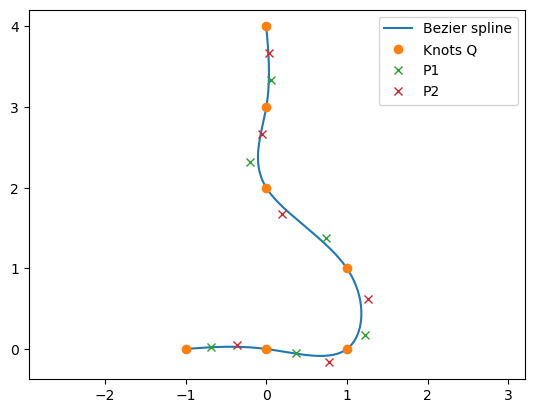

In [110]:
# (Optional) quick visualization to confirm smooth interpolation
import matplotlib.pyplot as plt

def sample_cubic_bezier(q0, p1, p2, q1, num=50):
    t = np.linspace(0, 1, num)[:, None]
    return ((1-t)**3) * q0 + 3*((1-t)**2)*t*p1 + 3*(1-t)*(t**2)*p2 + (t**3)*q1

# sample the spline
curve = []
for i in range(len(Q)-1):
    pts = sample_cubic_bezier(Q[i], P1[i], P2[i], Q[i+1], num=60)
    curve.append(pts)
curve = np.vstack(curve)

plt.figure()
plt.plot(curve[:,0], curve[:,1], label="Bezier spline")
plt.plot(Q[:,0], Q[:,1], "o", label="Knots Q")
plt.plot(P1[:,0], P1[:,1], "x", label="P1")
plt.plot(P2[:,0], P2[:,1], "x", label="P2")
plt.axis("equal")
plt.legend()
plt.show()


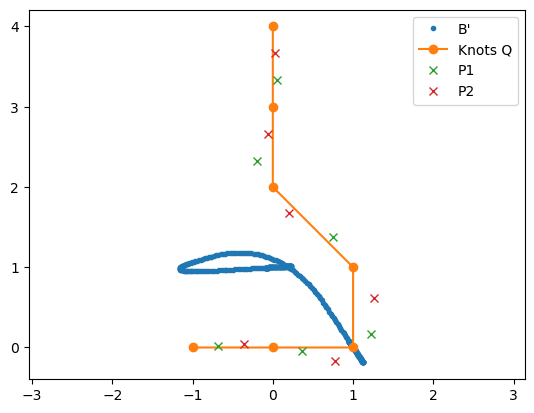

In [99]:
# (Optional) quick visualization to confirm smooth interpolation
import matplotlib.pyplot as plt

def sample_cubic_bezier(q0, p1, p2, q1, num=50):
    t = np.linspace(0, 1, num)[:, None]
    return -3*((1-t)**2) * q0 + (9*t**2 - 12*t + 3)*p1 + (-9*t**2 + 6*t)*p2 + 3*(t**2)*q1

# sample the spline
curve = []
for i in range(len(Q)-1):
    pts = sample_cubic_bezier(Q[i], P1[i], P2[i], Q[i+1], num=60)
    #curve.append(pts/np.linalg.norm(pts))
    v = [np.linalg.norm(p) for p in pts]
    curve.append(pts)
curve = np.vstack(curve)

plt.figure()
plt.plot(curve[:,0], curve[:,1], '.', label="B'")
plt.plot(Q[:,0], Q[:,1], "o-", label="Knots Q")
plt.plot(P1[:,0], P1[:,1], "x", label="P1")
plt.plot(P2[:,0], P2[:,1], "x", label="P2")
plt.axis("equal")
plt.legend()
plt.show()

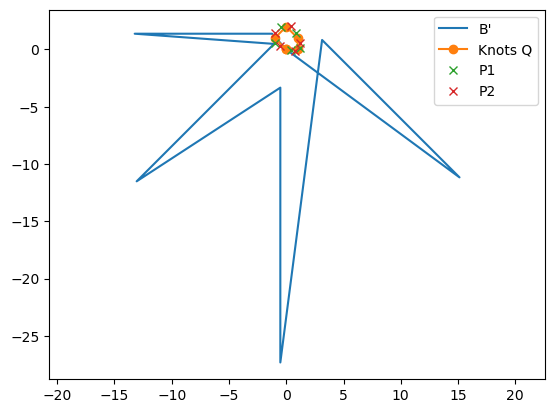

In [36]:
# (Optional) quick visualization to confirm smooth interpolation
import matplotlib.pyplot as plt

def sample_cubic_bezier(q0, p1, p2, q1, num=50):
    t = np.linspace(0, 1, num)[:, None]
    return -6*((1-t)) * q0 + (18*t-12)*p1 + (-18*t+6)*p2 + 6*t*q1

# sample the spline
curve = []
for i in range(len(Q)-1):
    pts = sample_cubic_bezier(Q[i], P1[i], P2[i], Q[i+1], num=60)
    curve.append(pts)
curve = np.vstack(curve)

plt.figure()
plt.plot(curve[:,0], curve[:,1], label="B''")
plt.plot(Q[:,0], Q[:,1], "o-", label="Knots Q")
plt.plot(P1[:,0], P1[:,1], "x", label="P1")
plt.plot(P2[:,0], P2[:,1], "x", label="P2")
plt.axis("equal")
plt.legend()
plt.show()

In [31]:
curve[:5]

array([[1.        , 0.        ],
       [1.12113377, 0.08259121],
       [1.23594752, 0.16087331],
       [1.34444125, 0.23484631],
       [1.44661496, 0.3045102 ]])

In [100]:
import numpy as np

def bezier_control_points_closed(Q):
    """
    Closed Bezier spline interpolation through points Q (periodic).
    
    Q: array-like shape (n, d)   n points, d dimensions (2 for 2D)
       The path is closed automatically (last connects to first).
    
    Returns:
        P1: shape (n, d)  first control points
        P2: shape (n, d)  second control points
    """
    Q = np.asarray(Q, dtype=float)
    if Q.ndim != 2 or Q.shape[0] < 3:
        raise ValueError("Q must be (n, d) with n >= 3 for a closed spline.")

    n, d = Q.shape

    # Build cyclic tridiagonal matrix A (n x n):
    # main diagonal = 4
    # sub/super diagonal = 1
    # plus wrap-around corners A[0,n-1]=1 and A[n-1,0]=1
    A = np.zeros((n, n))
    np.fill_diagonal(A, 4.0)
    for k in range(n-1):
        A[k, k+1] = 1.0
        A[k+1, k] = 1.0
    A[0, n-1] = 1.0
    A[n-1, 0] = 1.0

    # RHS: rhs_k = 4 Q_k + 2 Q_{k+1}
    rhs = np.zeros((n, d))
    for k in range(n):
        rhs[k] = 4 * Q[k] + 2 * Q[(k+1) % n]

    #print(A)
    #print(rhs)
    # Solve A P1 = rhs for each coordinate at once
    # (np.linalg.solve supports multiple RHS columns)
    P1 = np.linalg.solve(A, rhs)

    # Second control points:
    # P2_k = 2 Q_{k+1} - P1_{k+1}
    P2 = np.zeros_like(P1)
    for k in range(n):
        P2[k] = 2 * Q[(k+1) % n] - P1[(k+1) % n]

    return P1, P2


In [101]:
# -------- Example usage --------
Q = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [-1.0, 1.0],
    #[-0.75, 0.5],
    #[-0.25, 0.75],
    #[0.0, 0.0],
])  # 4 knots => n=3 Bezier segments

P1, P2 = bezier_control_points_closed(Q)
print("First control points (P1):\n", P1)
print("Second control points (P2):\n", P2)

[[4. 1. 0. 0. 1.]
 [1. 4. 1. 0. 0.]
 [0. 1. 4. 1. 0.]
 [0. 0. 1. 4. 1.]
 [1. 0. 0. 1. 4.]]
[[ 2.  0.]
 [ 6.  2.]
 [ 4.  8.]
 [-2. 10.]
 [-4.  4.]]
First control points (P1):
 [[ 0.45454545 -0.18181818]
 [ 1.18181818  0.18181818]
 [ 0.81818182  1.45454545]
 [-0.45454545  2.        ]
 [-1.          0.54545455]]
Second control points (P2):
 [[ 0.81818182 -0.18181818]
 [ 1.18181818  0.54545455]
 [ 0.45454545  2.        ]
 [-1.          1.45454545]
 [-0.45454545  0.18181818]]


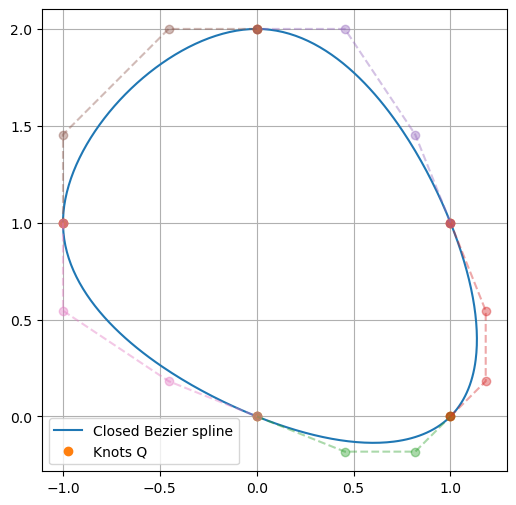

In [102]:
import matplotlib.pyplot as plt

def sample_cubic_bezier(Q0, P1, P2, Q1, num=80):
    t = np.linspace(0, 1, num)[:, None]
    return ((1-t)**3)*Q0 + 3*((1-t)**2)*t*P1 + 3*(1-t)*(t**2)*P2 + (t**3)*Q1

def plot_closed_bezier_spline(Q, P1, P2, num=80, show_ctrl=True):
    Q = np.asarray(Q, float)
    n = len(Q)

    curve = []
    for k in range(n):
        Q0 = Q[k]
        Q1 = Q[(k+1) % n]
        pts = sample_cubic_bezier(Q0, P1[k], P2[k], Q1, num=num)
        curve.append(pts)
    curve = np.vstack(curve)

    plt.figure(figsize=(6,6))
    plt.plot(curve[:,0], curve[:,1], label="Closed Bezier spline")
    plt.plot(Q[:,0], Q[:,1], "o", label="Knots Q")

    if show_ctrl:
        for k in range(n):
            Q0 = Q[k]
            Q1 = Q[(k+1)%n]
            ctrl = np.vstack([Q0, P1[k], P2[k], Q1])
            plt.plot(ctrl[:,0], ctrl[:,1], "o--", alpha=0.4)

    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_closed_bezier_spline(Q, P1, P2)